# Ensemble Learning

- Voting
- Bagging
- Boosting

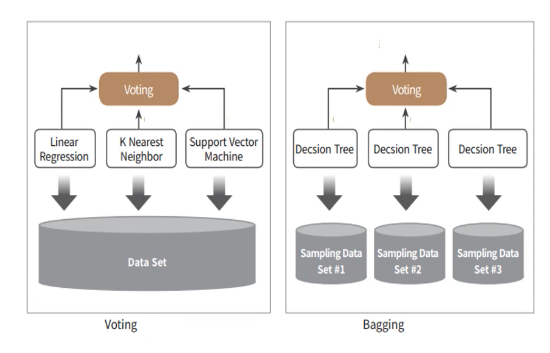

## 1. Voting

1. Hard Voting
2. **Soft Voting**

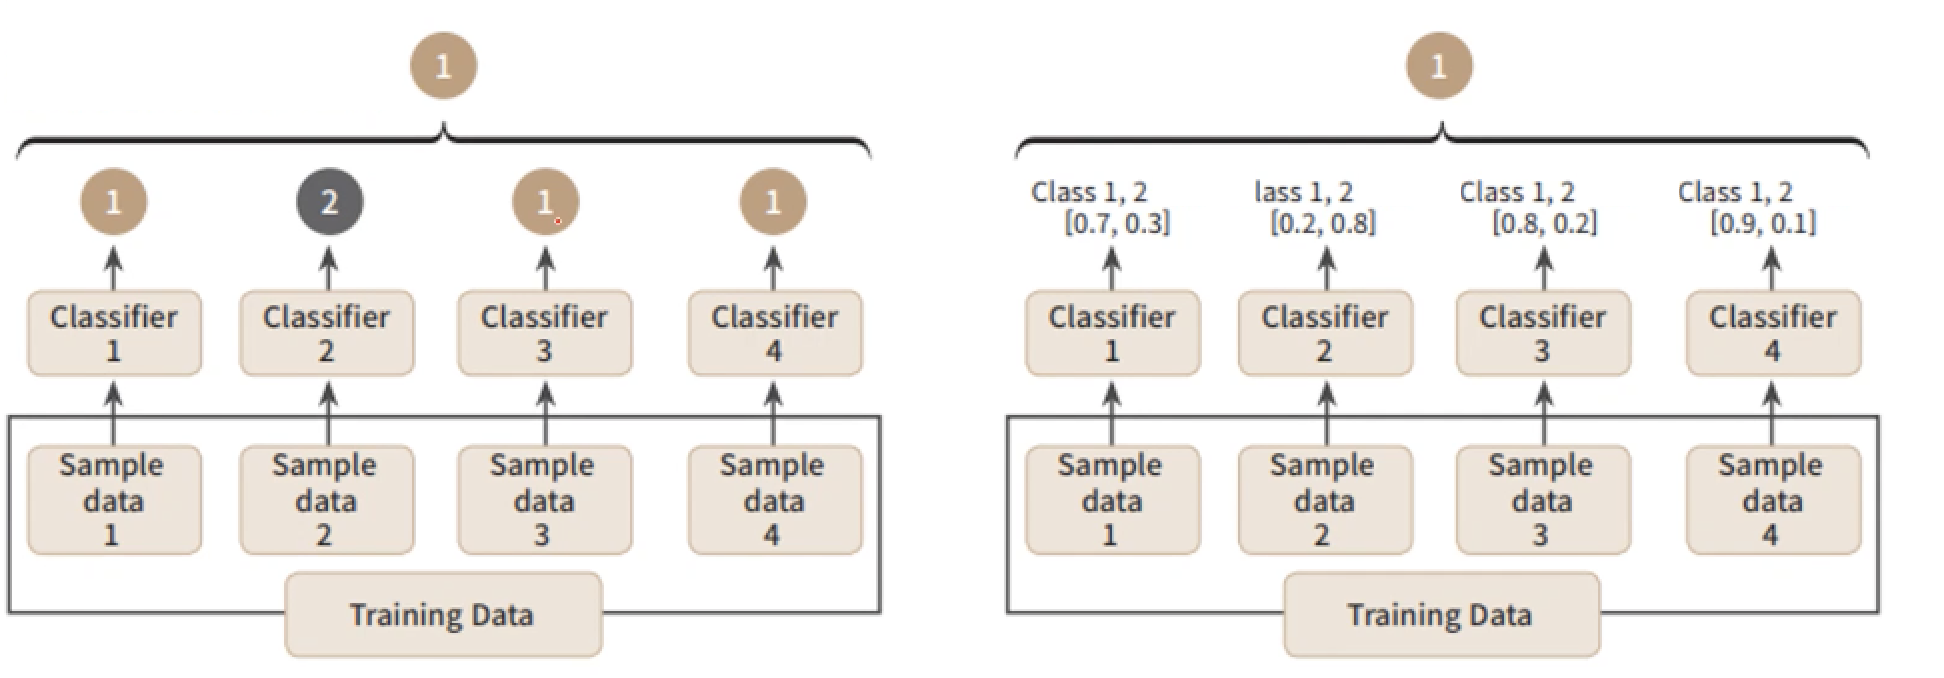

In [2]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf),('KNN',knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   test_size=0.2, random_state=156)

vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print('Voting Classifier Accuracy: {0:.4f}'.format(accuracy_score(y_test, pred)))

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} Accuracy : {1:.4f}'.format(class_name,accuracy_score(y_test, pred)))

Voting Classifier Accuracy: 0.9561
LogisticRegression Accuracy : 0.9474
KNeighborsClassifier Accuracy : 0.9386


## 2. Bagging

### Random Forest

In [7]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                             'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                             if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    
    feature_name_df = pd.read_csv('../data/human_activity/features.txt',sep='\s+',
                                 header=None,names=['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    X_train = pd.read_csv('../data/human_activity/train/X_train.txt',sep='\s+',names=feature_name)
    X_test = pd.read_csv('../data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('../data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('../data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    return X_train, X_test, y_train, y_test

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred=rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Random Forest Accuracy: {0:.4f}'.format(accuracy))

Random Forest Accuracy: 0.9196


### Random Forest Hyper Parameter and Tuning

In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('Optimal Hyper Parameter:\n', grid_cv.best_params_)
print('Best Accuracy: {0:.4f}'.format(grid_cv.best_score_))

Optimal Hyper Parameter:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best Accuracy: 0.9165


In [10]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                min_samples_split=2, random_state=0)

rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('Accuracy: {0:.4f}'.format(accuracy_score(y_test, pred)))

Accuracy: 0.9260


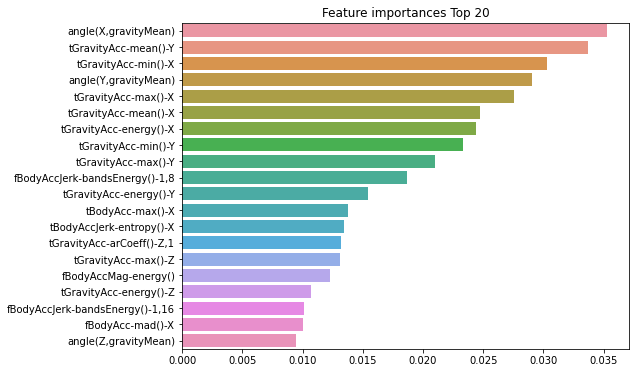

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## GBM (Gradient Boosting Machine)
- AdaBoost(Adaptive boosting)
- Gradient Boost

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM Accuracy: {0:.4f}'.format(gb_accuracy))
print("GBM Execution Time: {0:.4f} sec".format(time.time() - start_time))

GBM Accuracy: 0.9393
GBM Execution Time: 551.1561 sec
